In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import seaborn as sns
import configs
import os
import torch
from scipy.stats import pearsonr
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR  
import deer.controllers as bc 
import yaml
from scipy.stats import pearsonr
from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy  

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from deer.environments.Figure8 import MyEnv as Env

In [3]:
import torch
torch.cuda.is_available = lambda : False

In [82]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

internal_dim = 7
generic_exp_name = 'noisy_altT_eps0.5_volweight'

internal_dim = 28
generic_exp_name = 'vnoisy_altT_eps0.75'

test_noise = 0.

exp_name = f'{generic_exp_name}_dm_dim{internal_dim}'
latents_dir = f'{engram_dir}latents/{exp_name}/'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'

# Run test experiments

In [83]:
corr = []
stem_loc = []
score = []
model = []
for model_name in os.listdir(nnets_dir):
    print(model_name)
    if 'altT' not in model_name: continue
    if ('mf' not in model_name) and ('mb' not in model_name): continue
    fname = f'{generic_exp_name}_mb' if 'mb' in model_name else f'{generic_exp_name}_mf'
    
    with open(f'{engram_dir}params/{fname}.yaml', 'r') as f:
        parameters = yaml.safe_load(f)
    parameters['fname'] = f'{exp_name}/{model_name}'
    parameters['internal_dim'] = internal_dim
    env = Env(                                                                     
        give_rewards=parameters['figure8_give_rewards'],                           
        higher_dim_obs=parameters['higher_dim_obs'],                               
        show_rewards=parameters['show_rewards'], plotfig=False,
        obs_noise=test_noise
        ) 
    rng = np.random.RandomState()
    learning_algo = CRAR(                                                          
        env, parameters['freeze_interval'], parameters['batch_size'], rng,         
        internal_dim=parameters['internal_dim'], lr=parameters['learning_rate'],
        nn_yaml=parameters['nn_yaml'], yaml_mods=parameters['yaml_mods'],          
        double_Q=True, loss_weights=parameters['loss_weights'],                    
        encoder_type=parameters['encoder_type'], mem_len=parameters['mem_len'],
        train_len=parameters['train_len']  
        )   
    train_policy = EpsilonGreedyPolicy(                                     
        learning_algo, env.nActions(), rng, epsilon=1.)             
    test_policy = EpsilonGreedyPolicy(                                      
        learning_algo, env.nActions(), rng, 0.)  
    agent = NeuralAgent(                                                        
        env, learning_algo, parameters['replay_memory_size'], 1,                
        parameters['batch_size'], rng, save_dir=engram_dir,                     
        train_policy=train_policy, test_policy=test_policy)
    agent.attach(bc.LearningRateController(                                     
        initial_learning_rate=parameters['learning_rate'],                      
        learning_rate_decay=parameters['learning_rate_decay'],                  
        periodicity=1))                                                         
    agent.attach(bc.TrainerController(                                          
        evaluate_on='action',  periodicity=parameters['update_frequency'],      
        show_episode_avg_V_value=True, show_avg_Bellman_residual=True))         
    best_controller = bc.FindBestController(                                    
        validationID=Env.VALIDATION_MODE, testID=None, unique_fname=fname)      
    agent.attach(best_controller)                                               
    agent.attach(bc.InterleavedTestEpochController(                             
        id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],      
        periodicity=1, show_score=True, summarize_every=10, unique_fname=fname))
    try:
        agent.setNetwork(parameters['fname'] + '/fname', nEpoch=40)
    except:
        print(f'Skipping {model_name}')

    agent._in_episode = True
    agent._mode = 0 # Testing mode with plan_depth=0
    initState = env.reset(agent._mode)
    inputDims = env.inputDimensions()
    for i in range(len(inputDims)):
        if inputDims[i][0] > 1:
            agent._state[i][1:] = initState[i][1:]
    agent._Vs_on_last_episode = []
    is_terminal = False
    reward = 0

    xs = []
    ys = []
    latents = []
    reward_locs = []
    for i in range(100):
        obs = env.observe()
        for i in range(len(obs)):
            agent._state[i] = obs[i]    

            state = torch.as_tensor(agent._state).float()
            zs = torch.as_tensor(agent._latent).float()
            latent = agent._learning_algo.crar.encoder(state, zs=zs)
            latent = latent.detach().cpu().numpy()
            loc = list(np.unravel_index(
                np.argmax(obs[i]), obs[i].shape))
            xs.append(loc[0]-1)
            ys.append(loc[1]-1)
            latents.append(latent)
            reward_locs.append(env._reward_location)
            agent._latent[0, 0:-1] = agent._latent[0, 1:]
            agent._latent[0, -1] = latent

        V, action, reward_received = agent._step()
        reward += reward_received
        agent._Vs_on_last_episode.append(V)
        is_terminal = env.inTerminalState()
        if is_terminal: break     
    xs = np.array(xs)
    ys = np.array(ys)
    latents = np.array(latents).squeeze()
    reward_locs = np.array(reward_locs)
    
    # Record results
    midwidth = env.WIDTH//2
    for y in range(4):
        idxs = np.logical_and(xs==midwidth, ys==y)
        right_idxs = np.logical_and(idxs, reward_locs==env.RIGHT_REWARD)
        left_idxs = np.logical_and(idxs, reward_locs==env.LEFT_REWARD)
        try:
            _corr = pearsonr(
                np.mean(latents[right_idxs], axis=0),
                np.mean(latents[left_idxs], axis=0))[0]
            _corr = abs(_corr)
        except Exception as e:
            continue
        corr.append(_corr)
        stem_loc.append(y)
        score.append(reward)
        model.append(fname)

vnoisy_altT_eps0.75_mb_7
vnoisy_altT_eps0.75_mb_11
vnoisy_altT_eps0.75_mb_6
vnoisy_altT_eps0.75_mb_12
vnoisy_altT_eps0.75_mb_9
vnoisy_altT_eps0.75_mb_0
vnoisy_altT_eps0.75_mb_15
vnoisy_altT_eps0.75_mb_10
vnoisy_altT_eps0.75_mb_3
vnoisy_altT_eps0.75_mb_2
vnoisy_altT_eps0.75_mb_5
vnoisy_altT_eps0.75_mb_4
vnoisy_altT_eps0.75_mb_8
vnoisy_altT_eps0.75_mb_13
vnoisy_altT_eps0.75_mb_14
vnoisy_altT_eps0.75_mb_1


In [84]:
%matplotlib inline
df = pd.DataFrame({
    'score': score, 'corr': corr, 'model': model, 'stem_loc': stem_loc
    })

In [85]:
df[df['stem_loc']==0]

,score,corr,model,stem_loc
0,20,0.246101,vnoisy_altT_eps0.75_mb,0
4,19,0.430765,vnoisy_altT_eps0.75_mb,0
8,18,0.723111,vnoisy_altT_eps0.75_mb,0
12,19,0.231071,vnoisy_altT_eps0.75_mb,0
16,20,0.553804,vnoisy_altT_eps0.75_mb,0
20,20,0.867068,vnoisy_altT_eps0.75_mb,0
24,17,0.824217,vnoisy_altT_eps0.75_mb,0
28,18,0.738218,vnoisy_altT_eps0.75_mb,0
32,19,0.055415,vnoisy_altT_eps0.75_mb,0
36,18,0.448426,vnoisy_altT_eps0.75_mb,0


(0.0, 1.0)

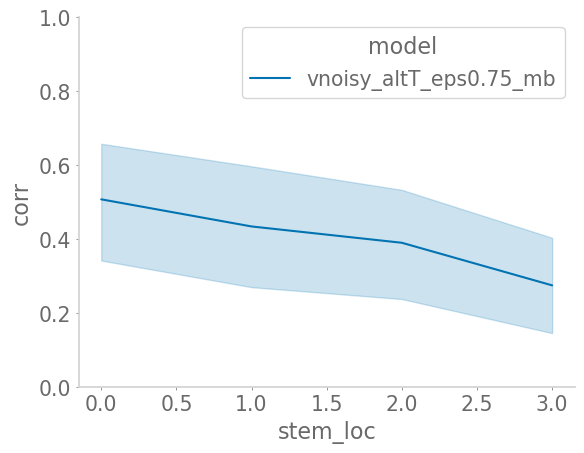

In [86]:
fig, ax = plt.subplots()
sns.lineplot(
    x='stem_loc', y='corr', hue='model',
    ax=ax,
    data=df[df['score']>=19],
    )
ax.set_ylim(0,1.)